In [1]:
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

import seaborn as sns

# To Scale our data
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# To perform KMeans clustering 
from sklearn.cluster import KMeans

color = sns.color_palette()
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from mlxtend.frequent_patterns import apriori, association_rules
import datetime as dt
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

from math import isnan
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading Data
retail = pd.read_csv("/Users/Vani/Documents/BlackCat/capstone/data-2.csv",sep = ',',encoding = "ISO-8859-1",header= 0)

In [3]:
# Data has 541K datapoints with 8 features
retail.shape

(541909, 8)

In [4]:
# structure of the data
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
retail.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
# Checking for null values
(retail.isnull().sum()/retail.shape[0])*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

<span style="color:blue">*Observations:*</span>
- CustomerId is missing for 25% of the transactions and imputation for CustomerID is not possible.

In [7]:
order_wise = retail.dropna()

In [8]:
order_wise.shape

(406829, 8)

In [9]:
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
order_wise['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

<span style="color:blue">*Observations:*</span>
- Dataset has transactions from 38 countries.

In [11]:
# Dropping duplicates
customer_country=order_wise[['Country','CustomerID']].drop_duplicates()

In [12]:
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


<span style="color:blue">*Observations:*</span>
- United Kingdom has lot of unique customers compared to other countries.

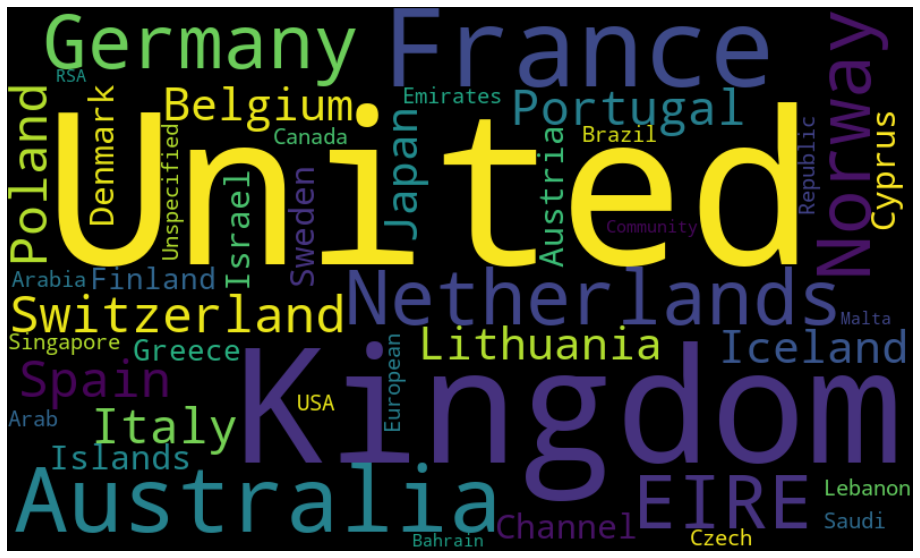

In [13]:
from wordcloud import WordCloud, STOPWORDS 
contents = list(customer_country['Country'].unique())
text = "" 
  
# iterating through list of rows 
for row in contents : 
    text = text + " " + row
wordcloud = WordCloud(width=800, height=480, max_words=50).generate(text) 
  
# plot the WordCloud image  
plt.figure(figsize=(20,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show() 


# Analysing customers of United Kingdom

In [14]:
df = order_wise.loc[order_wise['Country'] == 'United Kingdom']

In [51]:
df.to_csv('Data_clean.csv',index=False)

In [16]:
df.shape

(361878, 8)

# Creating TotalPrice feature

In [17]:
# Creating total Price column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [18]:
df['InvoiceDate'].min(),df['InvoiceDate'].max()

('1/10/2011 10:32', '9/9/2011 9:52')

In [19]:
NOW = dt.datetime(2011,12,11)
from datetime import datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Creating RFM(Recency,Frequency,Monetory Value Table)

In [20]:
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value'}, inplace=True)

In [21]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,326,2,0.00
12747.0,3,103,4196.01
12748.0,1,4642,29072.10
12749.0,4,231,3868.20
12820.0,4,59,942.34


<span style="color:blue">*Interpretation:*</span>
- CustomerID 12346 has frequency: 1, monetary value:  77,183.60 and recency: 325 days.
- CustomerID 12747 has frequency: 103, monetary value:77,183.60 and recency: 325 days.

#  Splitting the RFM table with 0.25,0.5,0.75 quantiles

In [22]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

<span style="color:blue">*Interpretation:*</span>
- The lowest recency, highest frequency and monetary amounts are our best customers.


In [23]:
segmented_rfm = rfmTable
segmented_rfm.describe()

,recency,frequency,monetary_value
count,3950.000000,3950.000000,3950.000000
mean,92.323038,91.614684,1713.385669
std,100.236848,220.557389,6548.608224
min,1.000000,1.000000,-4287.630000
25%,17.000000,17.000000,282.255000
50%,51.000000,41.000000,627.060000
75%,144.000000,101.000000,1521.782500
max,374.000000,7983.000000,256438.490000


In [45]:
def RScore(x,p,d):
    if x <= d[p][0.25]: # Recent Customers
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]: # Low frequency Customer and spending less amount
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

# Calculating scores for all the customers

In [46]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,CustomerID,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346.0,326,2,0.00,4,4,4,111
1,12747.0,3,103,4196.01,1,1,1,444
2,12748.0,1,4642,29072.10,1,1,1,444
3,12749.0,4,231,3868.20,1,1,1,444
4,12820.0,4,59,942.34,1,2,2,433


<span style="color:blue">*Interpretation:*</span>
- RFM Score 111 means Customer visited recently and Frequency is high and Spending is high too.
- RFM score 444 means Customer who visted the shop long back and the visits are low and spending is low too.

# Distribution of customers in 4 quantiles

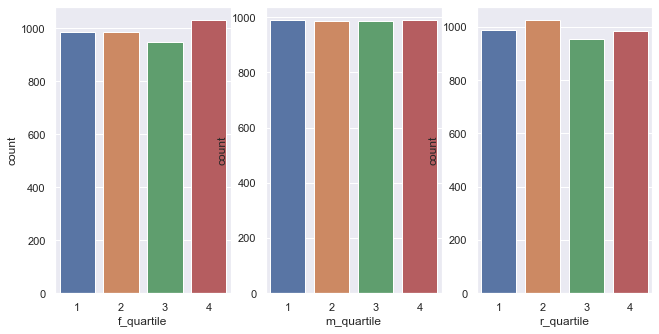

In [47]:
fig, axs = plt.subplots(ncols=3)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10.7,5.27)})

sns.countplot(x="f_quartile", data=segmented_rfm,ax=axs[0])

sns.countplot(x="m_quartile", data=segmented_rfm,ax=axs[1])
sns.countplot(x="r_quartile", data=segmented_rfm,ax=axs[2])
plt.show()

# Add a new column to combine RFM score: 


In [48]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,CustomerID,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346.0,326,2,0.00,4,4,4,444
1,12747.0,3,103,4196.01,1,1,1,111
2,12748.0,1,4642,29072.10,1,1,1,111
3,12749.0,4,231,3868.20,1,1,1,111
4,12820.0,4,59,942.34,1,2,2,122


<span style="color:blue">*Interpretation:*</span>
- RFM Score 111 means Customer visited recently and Frequency is high and Spending is high too.

# Top 10 best customers

In [49]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)

,CustomerID,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
3811,18102.0,1,433,256438.49,1,1,1,111
3340,17450.0,9,351,187482.17,1,1,1,111
3382,17511.0,3,1076,88125.38,1,1,1,111
2788,16684.0,5,281,65892.08,1,1,1,111
625,13694.0,4,585,62653.10,1,1,1,111
1783,15311.0,1,2491,59419.34,1,1,1,111
193,13089.0,3,1857,57385.88,1,1,1,111
909,14096.0,5,5128,57120.91,1,1,1,111
1591,15061.0,4,410,54228.74,1,1,1,111
2125,15769.0,8,147,51823.72,1,1,1,111


In [50]:

segmented_rfm.to_csv('RFM.csv',index=False)

In [31]:
# Resetting the index
segmented_rfm.reset_index(level=0, inplace=True)
RFM = segmented_rfm[['CustomerID','recency','frequency','monetary_value']]
RFM.head(2)

,CustomerID,recency,frequency,monetary_value
0,12346.0,326,2,0.00
1,12747.0,3,103,4196.01


# Checking for Outliers

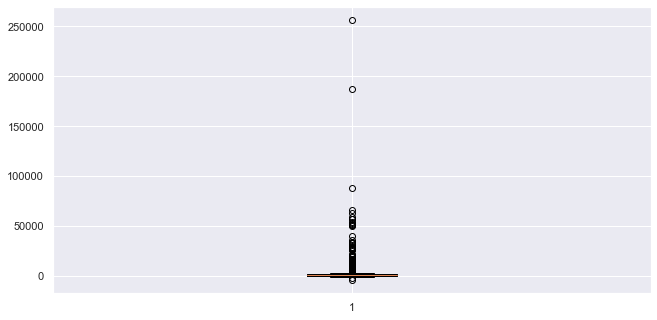

In [32]:
# Outliers for Monetory Value
plt.boxplot(RFM.monetary_value)
Q1 = RFM.monetary_value.quantile(0.25)
Q3 = RFM.monetary_value.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.monetary_value >= Q1 - 1.5*IQR) & (RFM.monetary_value <= Q3 + 1.5*IQR)] 
plt.show()

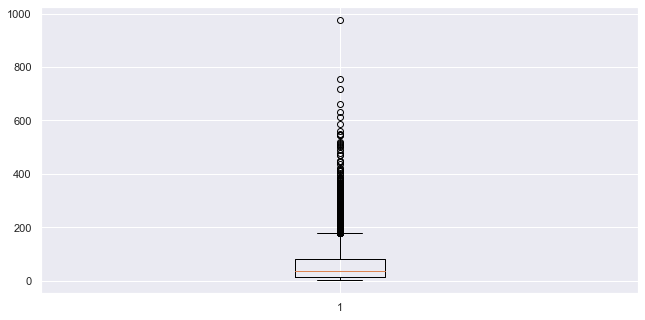

In [33]:
#outlier treatment for Frequency
plt.boxplot(RFM.frequency)
Q1 = RFM.frequency.quantile(0.25)
Q3 = RFM.frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.frequency >= Q1 - 1.5*IQR) & (RFM.frequency <= Q3 + 1.5*IQR)] #Tukey's Test

plt.show()

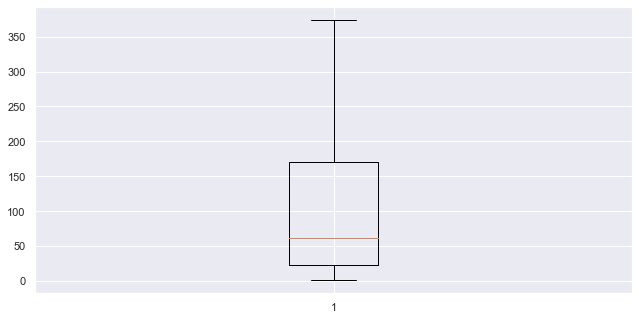

In [34]:
# outlier treatment for Recency
plt.boxplot(RFM.recency)
Q1 = RFM.recency.quantile(0.25)
Q3 = RFM.recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.recency >= Q1 - 1.5*IQR) & (RFM.recency <= Q3 + 1.5*IQR)]  

plt.show()

# Scaling the data

In [35]:
RFM_norm1 = RFM.drop("CustomerID", axis=1)

standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [36]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Requency','Frequency','Amount']
RFM_norm1.head()

,Requency,Frequency,Amount
0,2.146087,-1.061846,-1.054414
1,-0.973620,0.308098,0.301046
2,1.070660,-0.965710,-0.921046
3,-0.324489,0.019689,0.267445
4,-0.285735,-0.989744,1.476448


In [37]:
def hopkins(X):
    d = X.shape[1]
   
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H


In [38]:
print(hopkins(RFM_norm1))

0.8961231339715233


<span style="color:blue">*Interpretation:*</span>
- Hopkins score of .8 tells us high chances of clustering. 



# Sum of Squared Distances

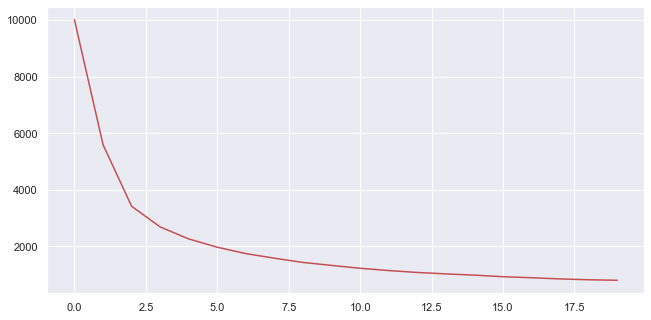

In [39]:
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd,'r')
plt.show()

<span style="color:blue">*Interpretation:*</span>
- Elbow plot helps us choosing the optimum number of clusters.
- Choosing number of clusters as 5.

# K-Means Clustering

In [40]:
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Clustering validation statistics

In [121]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

    


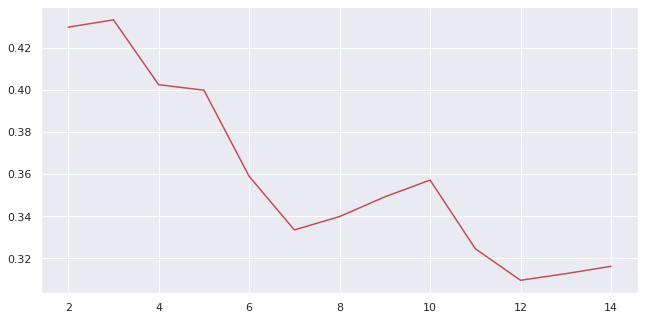

In [122]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1],'r')
plt.show()

<span style="color:blue">*Interpretation:*</span>
- silhouette_score for count of 5 clusters is 0.4 .
- Choosing number of clusters as 5.

In [123]:
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Recency', 'Frequency', 'Amount', 'ClusterID']


km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [124]:
RFM_km.head()

,CustomerID,Recency,Frequency,Amount,ClusterID
0,12346.0,326,2,0.00,2
1,12820.0,4,59,942.34,1
2,12821.0,215,6,92.72,2
3,12822.0,71,47,918.98,1
4,12823.0,75,5,1759.50,1


# Calculating mean of all clusters

In [125]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_recency, km_clusters_frequency, km_clusters_amount], axis=1)
df.columns = ["ClusterID","Recency_mean", "Frequency_mean","Amount_mean"]
df.head()

,ClusterID,Recency_mean,Frequency_mean,Amount_mean
0,0,55.245562,112.508876,817.109408
1,1,50.829352,53.738908,1219.455411
2,2,260.363088,20.481303,305.424596
3,3,57.559968,23.456712,355.014418
4,4,36.263158,117.594427,2333.649136


<span style="color:blue">*Interpretation:*</span>
- Cluster Analysis using Kmeans

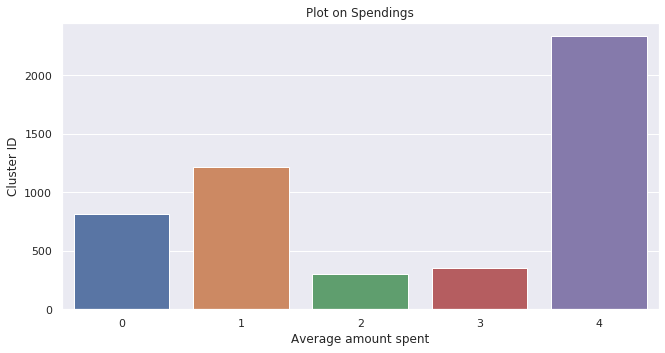

In [126]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)
plt.title("Plot on Spendings")
plt.xlabel("Average amount spent")
plt.ylabel("Cluster ID")
plt.show()

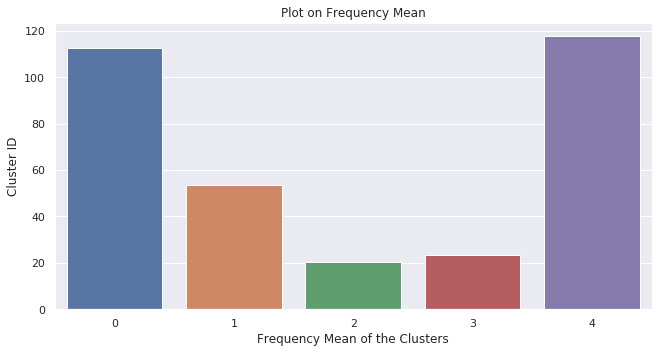

In [127]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)
plt.title("Plot on Frequency Mean")
plt.xlabel("Frequency Mean of the Clusters")
plt.ylabel("Cluster ID")
plt.show()

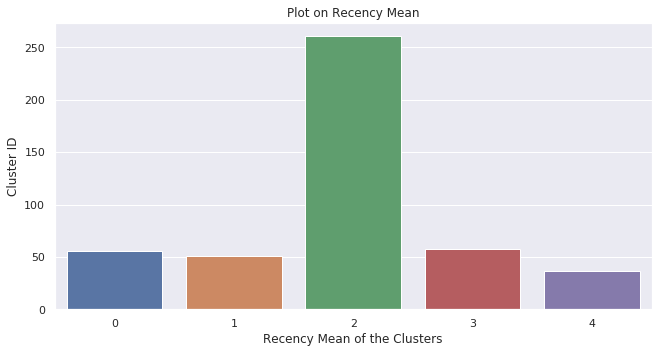

In [128]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)
plt.title("Plot on Recency Mean")
plt.xlabel("Recency Mean of the Clusters")
plt.ylabel("Cluster ID")
plt.show()

# Hierarchical Clustering

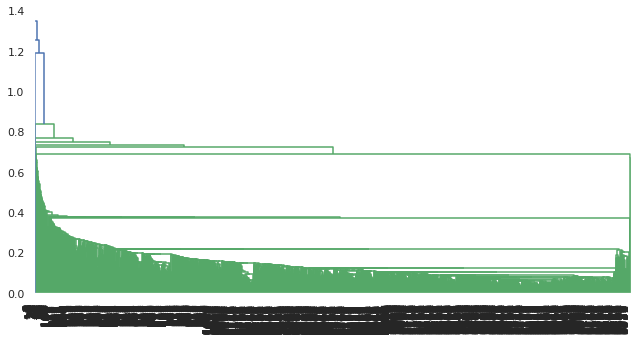

In [129]:
fig,ax = plt.subplots()
mergings = linkage(RFM_norm1, method = "single", metric='euclidean')
dendrogram(mergings)
ax.set_xticklabels(RFM_norm1.index,rotation=90,horizontalalignment = 'right',fontsize='12')
plt.show()

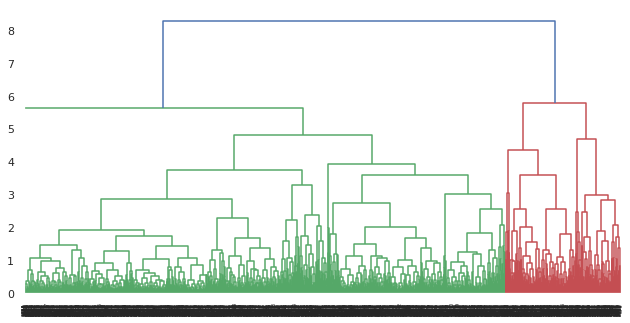

In [130]:
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

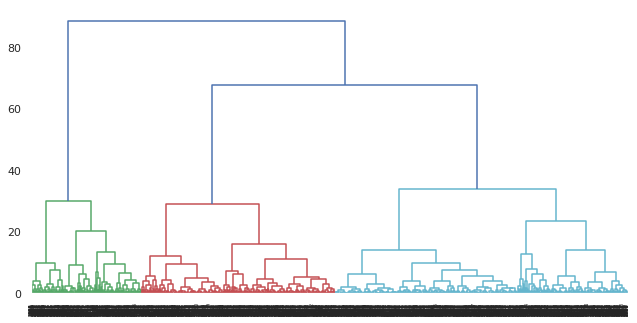

In [131]:
mergings = linkage(RFM_norm1, method = "ward", metric='euclidean')
dendrogram(mergings)
plt.show()

In [132]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 4).reshape(-1,))
RFM_hc = pd.concat([RFM, clusterCut], axis=1)
RFM_hc.columns = ['CustomerID', 'Recency','Frequency', 'Amount', 'ClusterID']

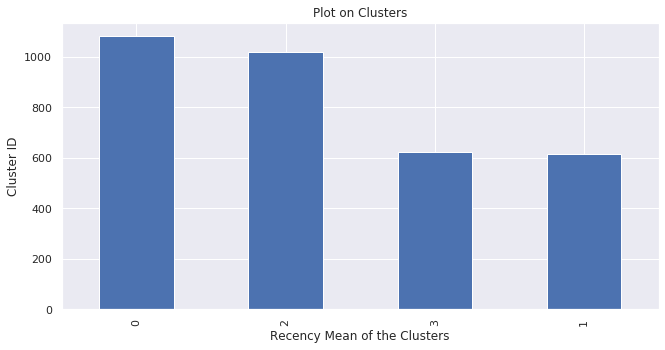

In [133]:
RFM_hc['ClusterID'].value_counts().plot(kind = 'bar')
plt.title("Plot on Clusters")
plt.ylabel("Recency Mean of the Clusters")
plt.xlabel("Cluster ID")
plt.show()


<span style="color:blue">*Interpretation:*</span>
- Cluster0 has got huge amount of customers and Cluster1 has a few customers 

In [134]:
RFM_hc['ClusterID'].value_counts()

0    1080
2    1019
3     621
1     615
Name: ClusterID, dtype: int64

In [135]:
RFM_hc.recency = RFM_hc.Recency
Hc_clusters_amount = pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
Hc_clusters_frequency = pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
Hc_clusters_recency = pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

# Hierarchical clustering Summary

In [136]:
df = pd.concat([pd.Series([0,1,2,3]), Hc_clusters_recency, Hc_clusters_frequency, Hc_clusters_amount], axis=1)
df.columns = ["ClusterID",  "Recency_mean" ,"Frequency_mean" , "Amount_mean"]
df.head()

,ClusterID,Recency_mean,Frequency_mean,Amount_mean
0,0,230.585185,23.464815,325.723019
1,1,45.726829,53.669919,1057.461740
2,2,42.991168,21.978410,392.004115
3,3,44.314010,117.983897,1679.775589


<span style="color:blue">*Interpretation Heirarchical Clustering:*</span>
- Among all the clusters cluster3 has  low Recency , high Frequency and high Spending.


In [137]:
import pickle
pickle.dump(RFM_hc, open('model.pkl','wb'))

In [138]:
model = pickle.load(open('model.pkl','rb'))

In [139]:
model.head()

,CustomerID,Recency,Frequency,Amount,ClusterID
0,12346.0,326,2,0.00,0
1,12820.0,4,59,942.34,1
2,12821.0,215,6,92.72,0
3,12822.0,71,47,918.98,1
4,12823.0,75,5,1759.50,1


In [52]:
df['StockCode'] = 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
